In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass

from pystac_client import Client  
# from pystac_client import ItemSearch

import json

import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
# from tqdm import tqdm

from shapely.geometry import box
from shapely.geometry import shape
from shapely.ops import transform
from shapely import wkt

import numpy as np
import pandas as pd
import geopandas as gpd
# from skimage import io

import rioxarray as rxr
import xarray as xr
import rasterio as rio

from osgeo import gdal
# from rioxarray.merge import merge_arrays

import pyproj
from pyproj import Proj

# import folium
# from folium import plugins
import geoviews as gv
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
gv.extension('bokeh', 'matplotlib')

import sys
sys.path.append('../../')
from src.dist_utils import intersection_percent, colorize, getbasemaps, transform_data_for_folium

import warnings
warnings.filterwarnings('ignore')

In [3]:
inDir = os.getcwd()
os.chdir(inDir)

In [4]:
# Generates authentication token
# Asks for your Earthdata username and password for first time, if netrc does not exists in your home directory.

urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system()=="Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

    # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)# GDAL configurations used to successfully access PODAAC Cloud Assets via vsicurl 


In [5]:
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF, TIFF')
gdal.SetConfigOption('CPL_VSIL_CURL_USE_HEAD', 'YES')# Filter datasets based on spatial overlap


In [6]:
# USER-DEFINED PARAMETERS
aoi = wkt.loads('POLYGON((-22.5271 63.8509,-22.3802 63.8509,-22.3802 63.8938,-22.5271 63.8938,-22.5271 63.8509))')

start_date = datetime(2024, 3, 1)                                       # in 2022-01-01 00:00:00 format
stop_date = datetime(2024, 8, 31)                                       # in 2022-01-01 00:00:00 format
# stop_date = f"{datetime.today().strftime('%Y-%m-%d')} 23:59:59"         # in 2022-01-01 00:00:00 format
overlap_threshold = 40                                                  # in percent
cloud_cover_threshold = 100                                             # in percent

save_fn = f"LavaFlowIceland_{datetime.strftime(start_date.date(), '%Y%m%d')}_{datetime.strftime(stop_date.date(), '%Y%m%d')}_v2"

print(f"Search between {start_date} and {stop_date}")
print(f"With AOI: {aoi.__geo_interface__}")

Search between 2024-03-01 00:00:00 and 2024-08-31 00:00:00
With AOI: {'type': 'Polygon', 'coordinates': (((-22.5271, 63.8509), (-22.3802, 63.8509), (-22.3802, 63.8938), (-22.5271, 63.8938), (-22.5271, 63.8509)),)}


In [7]:
# Search data through CMR-STAC API
stac = 'https://cmr.earthdata.nasa.gov/cloudstac/'    # CMR-STAC API Endpoint
api = Client.open(f'{stac}/LPCLOUD/')
collections = ['OPERA_L3_DIST-ALERT-HLS_V1']

search_params = {"collections": collections,
                 "intersects": aoi.__geo_interface__,
                 "datetime": [start_date, stop_date],
                 "max_items": 1000}
search_data = api.search(**search_params)

In [8]:
# Filter datasets based on spatial overlap 
intersects_geometry = aoi.__geo_interface__

#Check percent overlap values
print("Percent overlap before filtering: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in search_data.items()])

# Check percent cloud cover values
print("\nPercent cloud cover before filtering: ")
print([f"{i.properties['eo:cloud_cover']}" for i in search_data.items()])

# Apply spatial overlap and cloud cover filter
dist_filtered = (
    i for i in search_data.items() if ((intersection_percent(i, intersects_geometry) > overlap_threshold) & (i.properties['eo:cloud_cover'] <= cloud_cover_threshold))
)


Percent overlap before filtering: 
['100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '32.09', '100.00', '100.00', '28.14', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '26.39', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '30.58', '100.00', '100.00', '100.00', '30.60', '100.00', '100.00', '100.00', '100.00', '29.90', '100.00', '100.00', '30.70', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '15.48', '100.00', '100.00', '100.00', '30.50', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '30.37', '31.11', '100.00', '100.00', '100.00', '100.00', '27.83', '35.36', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '22.23', '100.00', '100.00', '20.55', '100.00', '100.00', '27.58', '100.00', '100.00', '35.24', '100.00', '28.26', '11.88', '100.00', '100.00', '43.36', '100.00', '100.00', '6.4

In [9]:
# Inspect the items inside the filtered query
dist_data = list(dist_filtered)
# Inspect one data
dist_data[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
 'id': 'OPERA_L3_DIST-ALERT-HLS_T27VVL_20240302T131301Z_20240304T164845Z_S2A_30_v1',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-21.415571, 63.0411322],
    [-20.8070327, 63.0426875],
    [-20.8002655, 64.0270166],
    [-23.0464985, 64.0127397],
    [-22.9996312, 63.3556837],
    [-21.415571, 63.0411322]]]},
 'bbox': [-23.046498, 63.041132, -20.800266, 64.027152],
 'properties': {'eo:cloud_cover': 2,
  'datetime': '2024-03-02T13:14:08.525000Z',
  'start_datetime': '2024-03-02T13:14:08.525Z',
  'end_datetime': '2024-03-02T13:14:08.525Z'},
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-HLS_V1.v1/items/OPERA_L3_DIST-ALERT-HLS_T27VVL_20240302T131301Z_20240304T164845Z_S2A_30_v1'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIS

In [10]:
## Print search information
# Tota granules
print(f"Total granules after search filter: {len(dist_data)}")

#Check percent overlap values
print("Percent-overlap: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in dist_data])

# Check percent cloud cover values
print("\nPercent cloud cover: ")
print([f"{i.properties['eo:cloud_cover']}" for i in dist_data])

Total granules after search filter: 81
Percent-overlap: 
['100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '100.00', '43.36', '100.00', '100.00', '100.00', '100.00']

Percent cloud cover: 
['2', '52', '100', '100', '98', '50', '100', '98', '98', '96', '90', '100', '6', '46', '6', '100', '51', '28',

In [11]:
# Visualize the DSWx tile boundary and the user-defined bbox
geom_df = []
for d,_ in enumerate(dist_data):
    geom_df.append(shape(dist_data[d].geometry))

geom_granules = gpd.GeoDataFrame({'geometry':geom_df})
granules_poly = gv.Polygons(geom_granules, label='DIST tile boundary').opts(line_color='blue', color=None, show_legend=True)

# Use geoviews to combine a basemap with the shapely polygon of our Region of Interest (ROI)
base = gv.tile_sources.EsriImagery.opts(width=1000, height=1000)

# Get the user-specified aoi
geom_aoi = shape(intersects_geometry)
aoi_poly = gv.Polygons(geom_aoi, label='User-specified bbox').opts(line_color='yellow', color=None, show_legend=True)

# Plot using geoviews wrapper
granules_poly*base*aoi_poly

:Overlay
   .Polygons.DIST_tile_boundary               :Polygons   [Longitude,Latitude]
   .WMTS.I                                    :WMTS   [Longitude,Latitude]
   .Polygons.User_hyphen_minus_specified_bbox :Polygons   [Longitude,Latitude]

In [12]:
# Create table of search results
dist_data_df = []
for item in dist_data:
    item.to_dict()
    fn = item.id.split('_')
    ID = fn[3]
    fileID = item.id
    sensor = fn[6]
    # dat = item.datetime.strftime('%Y-%m-%d')
    dat = item.datetime
    spatial_overlap = intersection_percent(item, intersects_geometry)
    cloud_cover = item.properties['eo:cloud_cover']
    geom = item.geometry
    bbox = item.bbox

    # Take all the band href information 
    band_links = [item.assets[links].href for links in item.assets.keys()]
    dist_data_df.append([ID,fileID,sensor,dat,geom,bbox,spatial_overlap,cloud_cover,band_links])

dist_data_df = pd.DataFrame(dist_data_df, columns = ['TileID', 'FileID', 'Sensor', 'Date', 'Coords', 'bbox', 'SpatialOverlap', 'CloudCover', 'BandLinks'])
dist_data_df = dist_data_df.drop_duplicates(subset='Date', ignore_index=True)
dist_data_df

TileID                                             FileID Sensor  \
0   T27VVL  OPERA_L3_DIST-ALERT-HLS_T27VVL_20240302T131301...    S2A   
1   T27VVL  OPERA_L3_DIST-ALERT-HLS_T27VVL_20240304T130259...    S2B   
2   T27VVL  OPERA_L3_DIST-ALERT-HLS_T27VVL_20240306T124625...     L9   
3   T27VVL  OPERA_L3_DIST-ALERT-HLS_T27VVL_20240309T130301...    S2A   
4   T27VVL  OPERA_L3_DIST-ALERT-HLS_T27VVL_20240312T131301...    S2A   
..     ...                                                ...    ...   
73  T27VVL  OPERA_L3_DIST-ALERT-HLS_T27VVL_20240822T132231...    S2A   
74  T27VVL  OPERA_L3_DIST-ALERT-HLS_T27VVL_20240824T131259...    S2B   
75  T27VVL  OPERA_L3_DIST-ALERT-HLS_T27VVL_20240826T130301...    S2A   
76  T27VVL  OPERA_L3_DIST-ALERT-HLS_T27VVL_20240829T124600...     L9   
77  T27VVL  OPERA_L3_DIST-ALERT-HLS_T27VVL_20240829T131251...    S2A   

                               Date  \
0  2024-03-02 13:14:08.525000+00:00   
1  2024-03-04 13:04:06.333000+00:00   
2  2024-03-06 12:46:25.506000+00:00   
3  2024-03-09 13:04:11.097000+00:00   
4  2024-03-12 13:14:09.166000+00:00   
..                              ...   
73 2024-08-22 13:24:00.394000+00:00   
74 2024-08-24 13:14:09.246000+00:00   
75 2024-08-26 13:04:08.366000+00:00   
76 2024-08-29 12:46:00.906000+00:00   
77 2024-08-29 13:14:06.559000+00:00   

                                               Coords  \
0   {'type': 'Polygon', 'coordinates': [[[-21.4155...   
1   {'type': 'Polygon', 'coordinates': [[[-20.8069...   
2   {'type': 'Polygon', 'coordinates': [[[-20.8059...   
3   {'type': 'Polygon', 'coordinates': [[[-20.8070...   
4   {'type': 'Polygon', 'coordinates': [[[-22.2837...   
..                                                ...   
73  {'type': 'Polygon', 'coordinates': [[[-22.8620...   
74  {'type': 'Polygon', 'coordinates': [[[-22.2493...   
75  {'type': 'Polygon', 'coordinates': [[[-20.8068...   
76  {'type': 'Polygon', 'coordinates': [[[-20.8058...   
77  {'type': 'Polygon', 'coordinates': [[[-21.4007...   

                                              bbox  SpatialOverlap  \
0   [-23.046498, 63.041132, -20.800266, 64.027152]      100.000000   
1   [-23.046498, 63.061535, -20.800266, 64.027152]      100.000000   
2   [-23.046498, 63.207201, -20.800266, 64.027152]      100.000000   
3    [-23.046498, 63.04161, -20.800266, 64.027152]      100.000000   
4   [-23.046498, 63.035922, -20.800266, 64.027152]      100.000000   
..                                             ...             ...   
73  [-23.046498, 63.481436, -22.311578, 64.021235]       43.362454   
74   [-23.046498, 63.03623, -20.800266, 64.027152]      100.000000   
75  [-23.046498, 63.065036, -20.800266, 64.027152]      100.000000   
76   [-23.046498, 63.21824, -20.800266, 64.027152]      100.000000   
77  [-23.046498, 63.041175, -20.800266, 64.027152]      100.000000   

    CloudCover                                          BandLinks  
0            2  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
1           52  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
2          100  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
3          100  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
4           98  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
..         ...                                                ...  
73          84  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
74          90  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
75          25  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
76          37  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
77          39  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  

[78 rows x 9 columns]

In [13]:
# Take one of the dist dataset and check what files are included. 
dist_data_df.iloc[0].BandLinks

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T27VVL_20240302T131301Z_20240304T164845Z_S2A_30_v1/OPERA_L3_DIST-ALERT-HLS_T27VVL_20240302T131301Z_20240304T164845Z_S2A_30_v1_VEG-DIST-STATUS.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T27VVL_20240302T131301Z_20240304T164845Z_S2A_30_v1/OPERA_L3_DIST-ALERT-HLS_T27VVL_20240302T131301Z_20240304T164845Z_S2A_30_v1_VEG-IND.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T27VVL_20240302T131301Z_20240304T164845Z_S2A_30_v1/OPERA_L3_DIST-ALERT-HLS_T27VVL_20240302T131301Z_20240304T164845Z_S2A_30_v1_VEG-ANOM.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T27VVL_20240302T131301Z_20240304T164845Z_S2A_30_v1/OPERA_L3_DIST-ALERT-HLS_T27VVL_20240302T131301Z_20240304T164

In [14]:
def stack_bands(bandpath:str, bandlist:list): 
    '''
    Returns geocube with three bands stacked into one multi-dimensional array.
            Parameters:
                    bandpath (str): Path to bands that should be stacked
                    bandlist (list): Three bands that should be stacked
            Returns:
                    bandStack (xarray Dataset): Geocube with stacked bands
                    crs (int): Coordinate Reference System corresponding to bands

   '''
    bandStack = []; bandS = []; bandStack_ = [];
    for i,band in enumerate(bandlist):
        if i==0:
            print(f"{bandpath%band}")
            bandStack_ = rxr.open_rasterio(bandpath%band)
            crs = bandStack_.rio.crs.to_epsg()
            bandStack = bandStack_.squeeze(drop=True)
            bandStack = bandStack.to_dataset(name='z')
            bandStack.coords['band'] = i+1
            bandStack = bandStack.rename({'x':'longitude', 'y':'latitude', 'band':'band'})
            bandStack = bandStack.expand_dims(dim='band')  
        else:
            bandS = rxr.open_rasterio(bandpath%band)
            bandS = bandS.squeeze(drop=True)
            bandS = bandS.to_dataset(name='z')
            bandS.coords['band'] = i+1
            bandS = bandS.rename({'x':'longitude', 'y':'latitude', 'band':'band'})
            bandS = bandS.expand_dims(dim='band')
            bandStack = xr.concat([bandStack, bandS], dim='band')
    return bandStack, crs

In [15]:
data_dir = f"https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/{fileID}/{fileID}_"
bandlist = ['VEG-DIST-STATUS', 'VEG-ANOM-MAX', 'VEG-DIST-DATE', 'VEG-DIST-DUR']
bandpath = f"{data_dir}%s.tif"

In [16]:
fileID

'OPERA_L3_DIST-ALERT-HLS_T27VVL_20240829T131251Z_20240905T003800Z_S2A_30_v1'

In [17]:
# Creates geocube of stacked bands
da, crs = stack_bands(bandpath, bandlist)

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T27VVL_20240829T131251Z_20240905T003800Z_S2A_30_v1/OPERA_L3_DIST-ALERT-HLS_T27VVL_20240829T131251Z_20240905T003800Z_S2A_30_v1_VEG-DIST-STATUS.tif


In [18]:
da

<xarray.Dataset> Size: 107MB
Dimensions:      (band: 4, latitude: 3660, longitude: 3660)
Coordinates:
  * longitude    (longitude) float64 29kB 4e+05 4e+05 ... 5.097e+05 5.097e+05
  * latitude     (latitude) float64 29kB 7.1e+06 7.1e+06 ... 6.99e+06 6.99e+06
    spatial_ref  int64 8B 0
  * band         (band) int64 32B 1 2 3 4
Data variables:
    z            (band, latitude, longitude) int16 107MB 255 255 255 ... -1 -1

In [19]:
# Creates basemap
base = gv.tile_sources.EsriTerrain.opts(width=1000, height=1000, padding=0.1)

In [20]:
base = gv.tile_sources.EsriNatGeo.opts(width=1000, height=1000, padding=0.1)
veg_dist_status = da.z.sel({'band':1})
veg_dist_status.hvplot.image(x='longitude', 
                          y='latitude', 
                          crs=crs, 
                          rasterize=True, 
                          dynamic=True, 
                          aspect='equal', 
                          frame_width=500, 
                          frame_height=500, 
                          cmap='hot_r', 
                          clim=(0,4), alpha=0.8).opts(title=f"VEG_DIST_STATUS", xlabel='Longitude', ylabel='Latitude') * base



:DynamicMap   []
   :Overlay
      .Image.I :Image   [longitude,latitude]   (Vegetation_disturbance_status)
      .WMTS.I  :WMTS   [Longitude,Latitude]

In [21]:
veg_anom_max = da.z.sel({'band':2})
veg_anom_max.hvplot.image(x='longitude', 
                          y='latitude', 
                          crs=crs, 
                          rasterize=True, 
                          dynamic=True, 
                          aspect='equal', 
                          frame_width=500, 
                          frame_height=500, 
                          cmap='hot_r', 
                          clim=(0,100), alpha=0.8).opts(title=f"VEG_ANOM_MAX", xlabel='Longitude', ylabel='Latitude') * base

:DynamicMap   []
   :Overlay
      .Image.I :Image   [longitude,latitude]   (Vegetation_disturbance_status)
      .WMTS.I  :WMTS   [Longitude,Latitude]

In [22]:
veg_dist_date = da.z.sel({'band':3})
veg_dist_date.hvplot.image(x='longitude', 
                          y='latitude', 
                          crs=crs, 
                          rasterize=True, 
                          dynamic=True, 
                          aspect='equal', 
                          frame_width=500, 
                          frame_height=500, 
                          cmap='viridis', 
                          clim=(0,1400), alpha=0.8).opts(title=f"VEG_DIST_DATE", xlabel='Longitude', ylabel='Latitude') * base

:DynamicMap   []
   :Overlay
      .Image.I :Image   [longitude,latitude]   (Vegetation_disturbance_status)
      .WMTS.I  :WMTS   [Longitude,Latitude]

In [23]:
veg_dist_dur = da.z.sel({'band':4})
veg_dist_dur.hvplot.image(x='longitude', 
                          y='latitude', 
                          crs=crs, 
                          rasterize=True, 
                          dynamic=True, 
                          aspect='equal', 
                          frame_width=500, 
                          frame_height=500, 
                          cmap='viridis', 
                          clim=(0,200), alpha=0.8).opts(title=f"VEG_DIST_DUR", xlabel='Longitude', ylabel='Latitude') * base

:DynamicMap   []
   :Overlay
      .Image.I :Image   [longitude,latitude]   (Vegetation_disturbance_status)
      .WMTS.I  :WMTS   [Longitude,Latitude]

In [24]:
dist_data_df.iloc[-1].bbox

[-23.046498, 63.041175, -20.800266, 64.027152]

In [25]:
dist_data_df.iloc[-1].BandLinks[0].split('_')

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA',
 'L3',
 'DIST-ALERT-HLS',
 'V1/OPERA',
 'L3',
 'DIST-ALERT-HLS',
 'T27VVL',
 '20240829T131251Z',
 '20240905T003800Z',
 'S2A',
 '30',
 'v1/OPERA',
 'L3',
 'DIST-ALERT-HLS',
 'T27VVL',
 '20240829T131251Z',
 '20240905T003800Z',
 'S2A',
 '30',
 'v1',
 'VEG-DIST-STATUS.tif']

In [26]:
dist_data_df.iloc[-1].BandLinks[0].split('/')

['https:',
 '',
 'data.lpdaac.earthdatacloud.nasa.gov',
 'lp-prod-protected',
 'OPERA_L3_DIST-ALERT-HLS_V1',
 'OPERA_L3_DIST-ALERT-HLS_T27VVL_20240829T131251Z_20240905T003800Z_S2A_30_v1',
 'OPERA_L3_DIST-ALERT-HLS_T27VVL_20240829T131251Z_20240905T003800Z_S2A_30_v1_VEG-DIST-STATUS.tif']

In [27]:
def read_dist(tiffile):
    print(f"{tiffile}")
    dat = rxr.open_rasterio(tiffile)
    epsg = dat.rio.crs.to_proj4()
    dat.closed
    
    return dat, epsg

In [28]:
#load dist
aoi = 'POLYGON((-22.5142 63.8324,-22.1934 63.8324,-22.1934 63.9708,-22.5142 63.9708,-22.5142 63.8324))'

time_coords = []; filepaths_vds=[]; filepaths_vam=[]; filepaths_dat=[]; filepaths_dur=[]; bbox = []
for i, fileID, start_date, bounding_polygon in zip(dist_data_df.index, dist_data_df.FileID, dist_data_df.Date, dist_data_df.bbox):
    data_dir = f"https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/{fileID}/{fileID}_"
    filepaths_vds.append(f"{data_dir}{bandlist[0]}.tif")
    filepaths_vam.append(f"{data_dir}{bandlist[1]}.tif")
    filepaths_dat.append(f"{data_dir}{bandlist[2]}.tif")
    filepaths_dur.append(f"{data_dir}{bandlist[3]}.tif")
    time_coords.append(pd.to_datetime(start_date))
    bbox.append(bounding_polygon)

In [29]:
def read_dist_ts(filepaths, time_coords):
    data_arrays = [rxr.open_rasterio(fp) for fp in filepaths]
    combined_data = xr.concat(data_arrays, dim='time')
    combined_data["time"] = time_coords
    epsg = data_arrays[0].rio.crs.to_proj4()
    return combined_data, epsg

In [30]:
vds_ts, epsg = read_dist_ts(filepaths_vds, time_coords)
vds_ts = vds_ts.squeeze("band")

In [31]:
vds = vds_ts.copy()
vds.rio.write_crs(f"epsg:{epsg.split(':')[-1]}", inplace=True)

<xarray.DataArray (time: 78, y: 3660, x: 3660)> Size: 1GB
array([[[255, 255, 255, ...,   1,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ...,   1,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ...,   1,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
...
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 29kB 7.1e+06 7.1e+06 7.1e+06 ... 6.99e+06 6.99e+06
  * time         (time) object 624B 2024-03-02T13:14:08.525000+00:00 ... 2024...
    spatial_ref  int64 8B 0
Attributes: (12/13)
    flag_meanings:             no_disturbance,firstdetection_<50%,provisional...
    flag_values:               0,1,2,3,4,5,6,7,8,255
    Input_DIST-ALERT_granule:  /OPERA_L3_DIST-ALERT-HLS_T27VVL_20240228T12401...
    Percent_Updated:           98.26
    Units:                     unitless
    Update_Date:               2024-03-02T13:14:08.525583Z
    ...                        ...
    Valid_min:                 0
    AREA_OR_POINT:             Area
    _FillValue:                255
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 Vegetation_disturbance_status

In [32]:
from pyproj import Transformer
xv, yv = np.meshgrid(vds.x, vds.y)

transformer = Transformer.from_crs(f"epsg:{epsg.split(':')[-1]}", 
                                   "epsg:4326",
                                   always_xy=True,
                                  ) 

lon, lat = transformer.transform(xv, yv)
vds.coords['lon'] = (('y', 'x'), lon)
vds.coords['lat'] = (('y', 'x'), lat)
vds.attrs['crs']  = '+init=epsg:4326'

In [33]:
%matplotlib inline

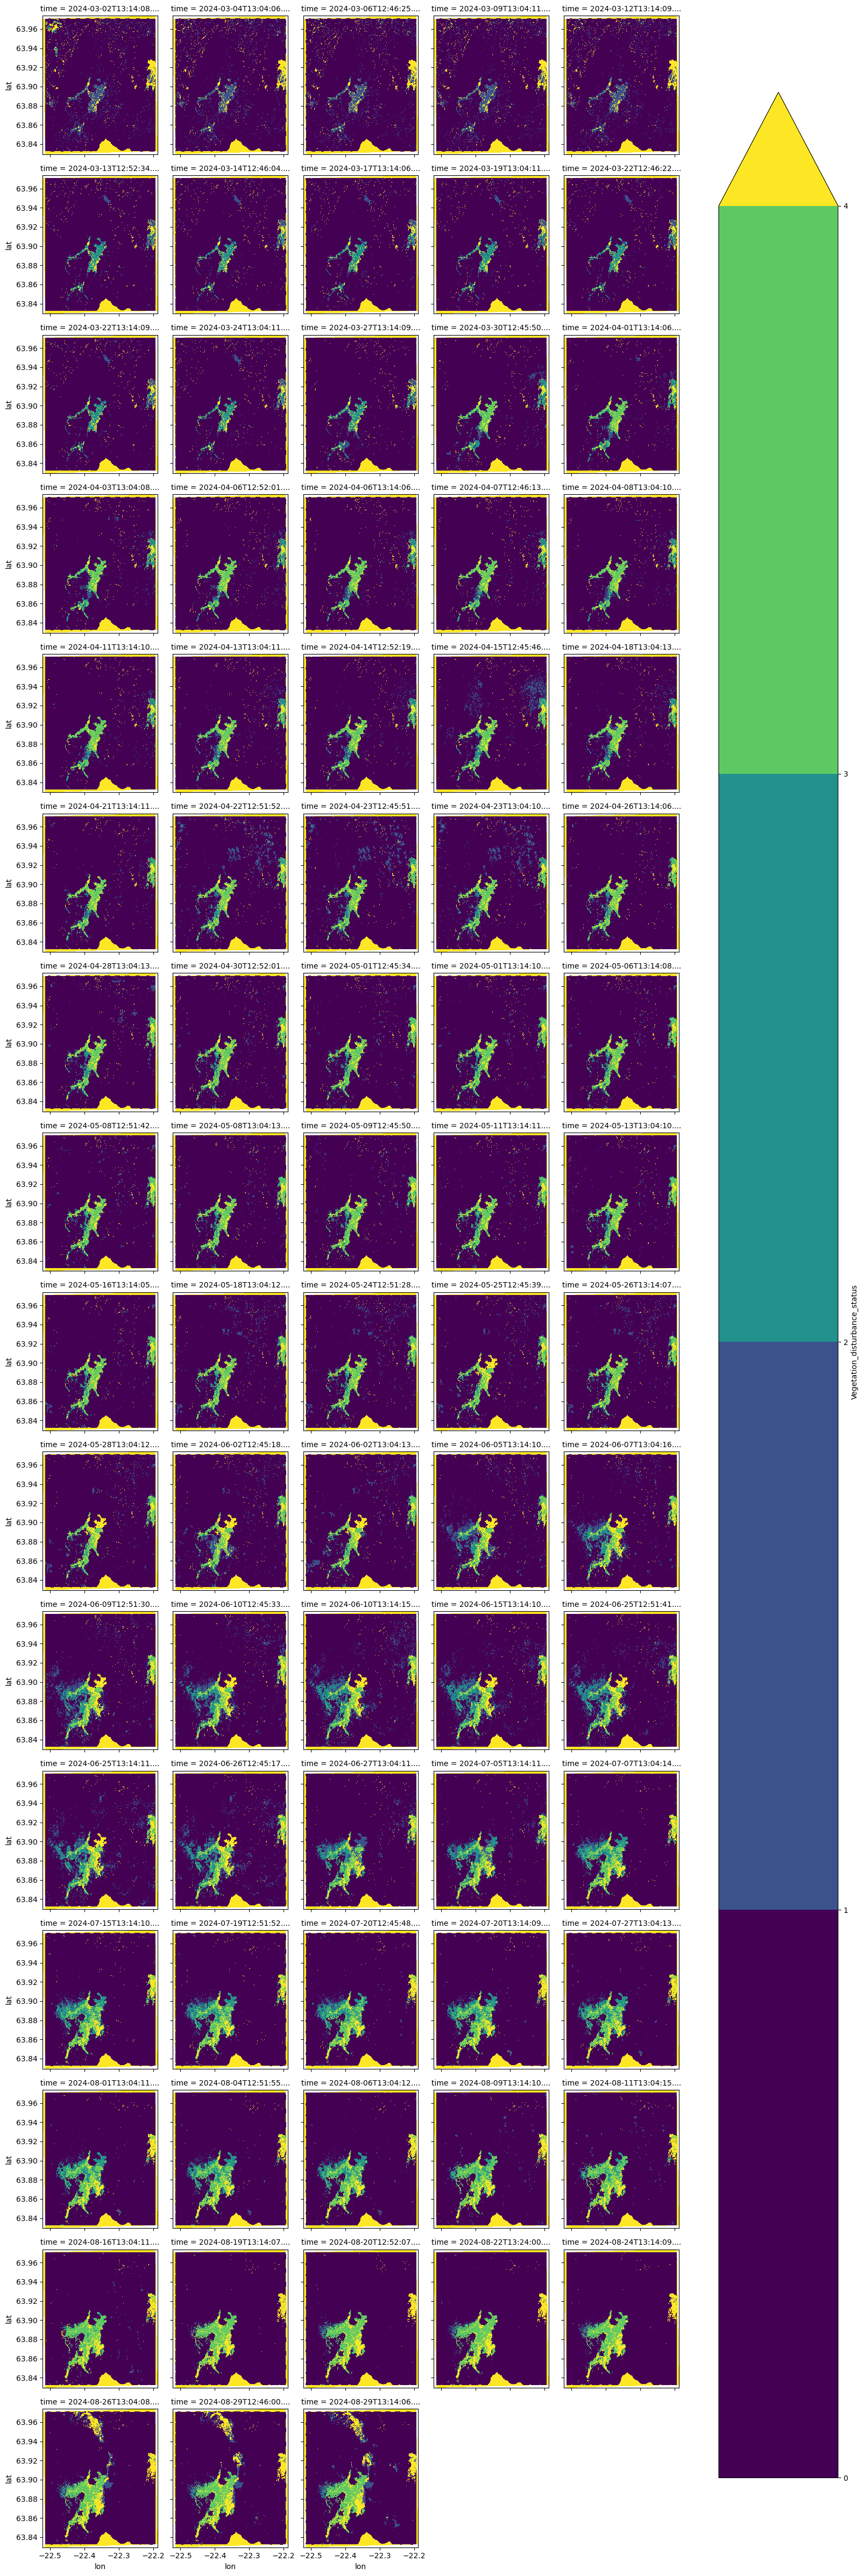

In [34]:
vds.rio.clip([wkt.loads(aoi)], "epsg:4326").plot(col='time', y='lat', x='lon', col_wrap=5, vmin=0, vmax=4, levels=5)

In [35]:
vam_ts, epsg = read_dist_ts(filepaths_vam, time_coords)
vam_ts = vam_ts.squeeze("band")

In [36]:
vam = vam_ts.copy()
vam.rio.write_crs(f"epsg:{epsg.split(':')[-1]}", inplace=True)

<xarray.DataArray (time: 78, y: 3660, x: 3660)> Size: 1GB
array([[[255, 255, 255, ...,  14,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ...,  14,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ...,  14,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
...
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 29kB 7.1e+06 7.1e+06 7.1e+06 ... 6.99e+06 6.99e+06
  * time         (time) object 624B 2024-03-02T13:14:08.525000+00:00 ... 2024...
    spatial_ref  int64 8B 0
Attributes:
    Input_DIST-ALERT_granule:  /OPERA_L3_DIST-ALERT-HLS_T27VVL_20240228T12401...
    Percent_Updated:           98.26
    Units:                     percent
    Update_Date:               2024-03-02T13:14:08.525583Z
    Valid_max:                 100
    Valid_min:                 0
    AREA_OR_POINT:             Area
    _FillValue:                255
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 Maximum_vegetation_loss_anomaly

In [37]:
xv, yv = np.meshgrid(vam.x, vam.y)
transformer = Transformer.from_crs(f"epsg:{epsg.split(':')[-1]}", 
                                   "epsg:4326",
                                   always_xy=True,
                                  ) 

lon, lat = transformer.transform(xv, yv)
vam.coords['lon'] = (('y', 'x'), lon)
vam.coords['lat'] = (('y', 'x'), lat)
vam.attrs['crs']  = '+init=epsg:4326'

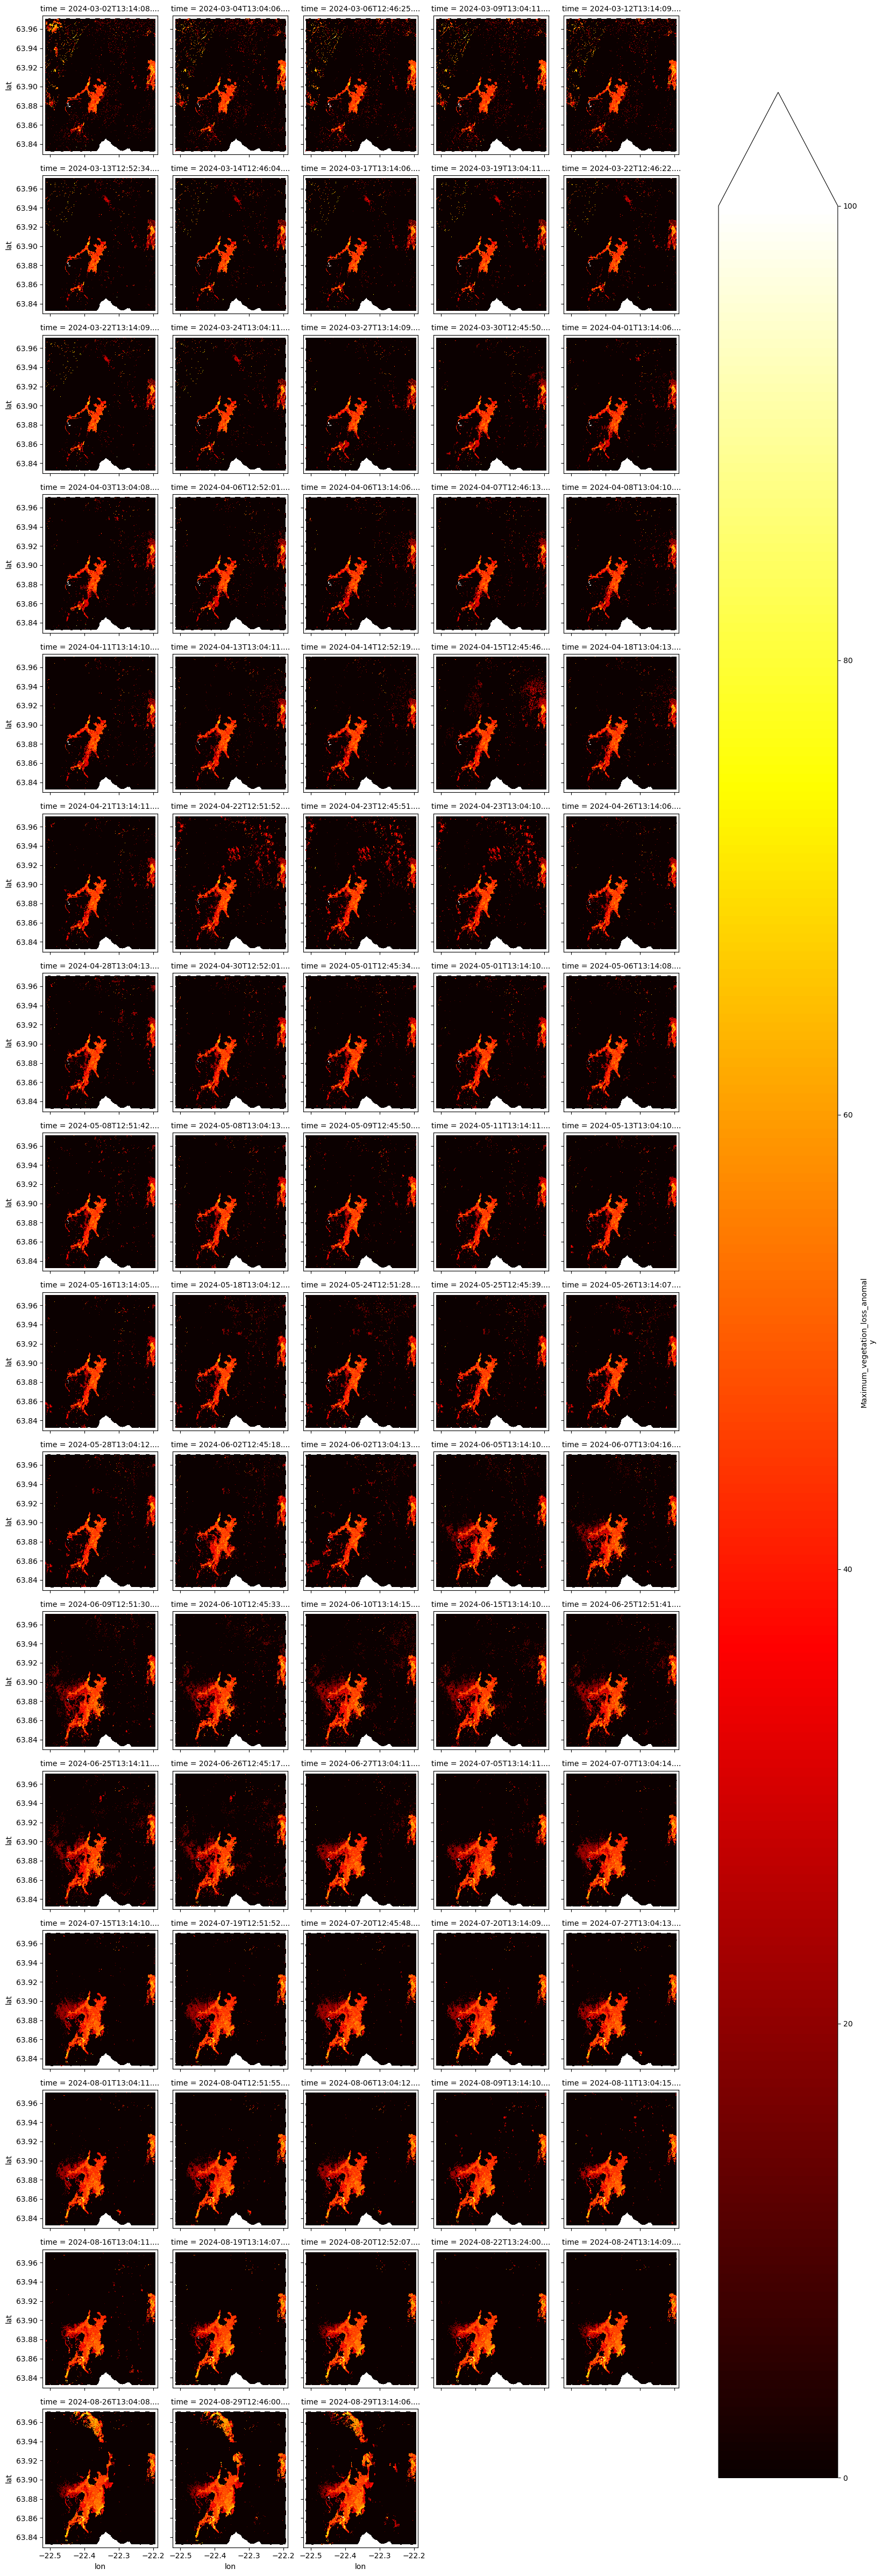

In [38]:
vam.rio.clip([wkt.loads(aoi)], "epsg:4326").plot(col='time', y='lat', x='lon', col_wrap=5, vmin=0, vmax=100, cmap='hot')

In [39]:
vdat_ts, epsg = read_dist_ts(filepaths_dat, time_coords)
vdat_ts = vdat_ts.squeeze("band")

In [40]:
vdt = vdat_ts.copy()
vdt.rio.write_crs(f"epsg:{epsg.split(':')[-1]}", inplace=True)

<xarray.DataArray (time: 78, y: 3660, x: 3660)> Size: 2GB
array([[[  -1,   -1,   -1, ..., 1026,    0,    0],
        [  -1,   -1,   -1, ...,    0,    0,    0],
        [  -1,   -1,   -1, ...,    0,    0,    0],
        ...,
        [  -1,   -1,   -1, ...,   -1,   -1,   -1],
        [  -1,   -1,   -1, ...,   -1,   -1,   -1],
        [  -1,   -1,   -1, ...,   -1,   -1,   -1]],

       [[  -1,   -1,   -1, ..., 1026,    0,    0],
        [  -1,   -1,   -1, ...,    0,    0,    0],
        [  -1,   -1,   -1, ...,    0,    0,    0],
        ...,
        [  -1,   -1,   -1, ...,   -1,   -1,   -1],
        [  -1,   -1,   -1, ...,   -1,   -1,   -1],
        [  -1,   -1,   -1, ...,   -1,   -1,   -1]],

       [[  -1,   -1,   -1, ..., 1026,    0,    0],
        [  -1,   -1,   -1, ...,    0,    0,    0],
        [  -1,   -1,   -1, ...,    0,    0,    0],
        ...,
...
        ...,
        [  -1,   -1,   -1, ...,   -1,   -1,   -1],
        [  -1,   -1,   -1, ...,   -1,   -1,   -1],
        [  -1,   -1,   -1, ...,   -1,   -1,   -1]],

       [[  -1,   -1,   -1, ...,    0,    0,    0],
        [  -1,   -1,   -1, ...,    0,    0,    0],
        [  -1,   -1,   -1, ...,    0,    0,    0],
        ...,
        [  -1,   -1,   -1, ...,   -1,   -1,   -1],
        [  -1,   -1,   -1, ...,   -1,   -1,   -1],
        [  -1,   -1,   -1, ...,   -1,   -1,   -1]],

       [[  -1,   -1,   -1, ...,    0,    0,    0],
        [  -1,   -1,   -1, ...,    0,    0,    0],
        [  -1,   -1,   -1, ...,    0,    0,    0],
        ...,
        [  -1,   -1,   -1, ...,   -1,   -1,   -1],
        [  -1,   -1,   -1, ...,   -1,   -1,   -1],
        [  -1,   -1,   -1, ...,   -1,   -1,   -1]]], dtype=int16)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 29kB 7.1e+06 7.1e+06 7.1e+06 ... 6.99e+06 6.99e+06
  * time         (time) object 624B 2024-03-02T13:14:08.525000+00:00 ... 2024...
    spatial_ref  int64 8B 0
Attributes:
    Input_DIST-ALERT_granule:  /OPERA_L3_DIST-ALERT-HLS_T27VVL_20240228T12401...
    Percent_Updated:           98.26
    Units:                     days
    Update_Date:               2024-03-02T13:14:08.525583Z
    Valid_max:                 1157
    Valid_min:                 0
    AREA_OR_POINT:             Area
    _FillValue:                -1
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 Day_of_vegetation_disturbance

In [41]:
xv, yv = np.meshgrid(vdt.x, vdt.y)
transformer = Transformer.from_crs(f"epsg:{epsg.split(':')[-1]}", 
                                   "epsg:4326",
                                   always_xy=True,
                                  ) 

lon, lat = transformer.transform(xv, yv)
vdt.coords['lon'] = (('y', 'x'), lon)
vdt.coords['lat'] = (('y', 'x'), lat)
vdt.attrs['crs']  = '+init=epsg:4326'

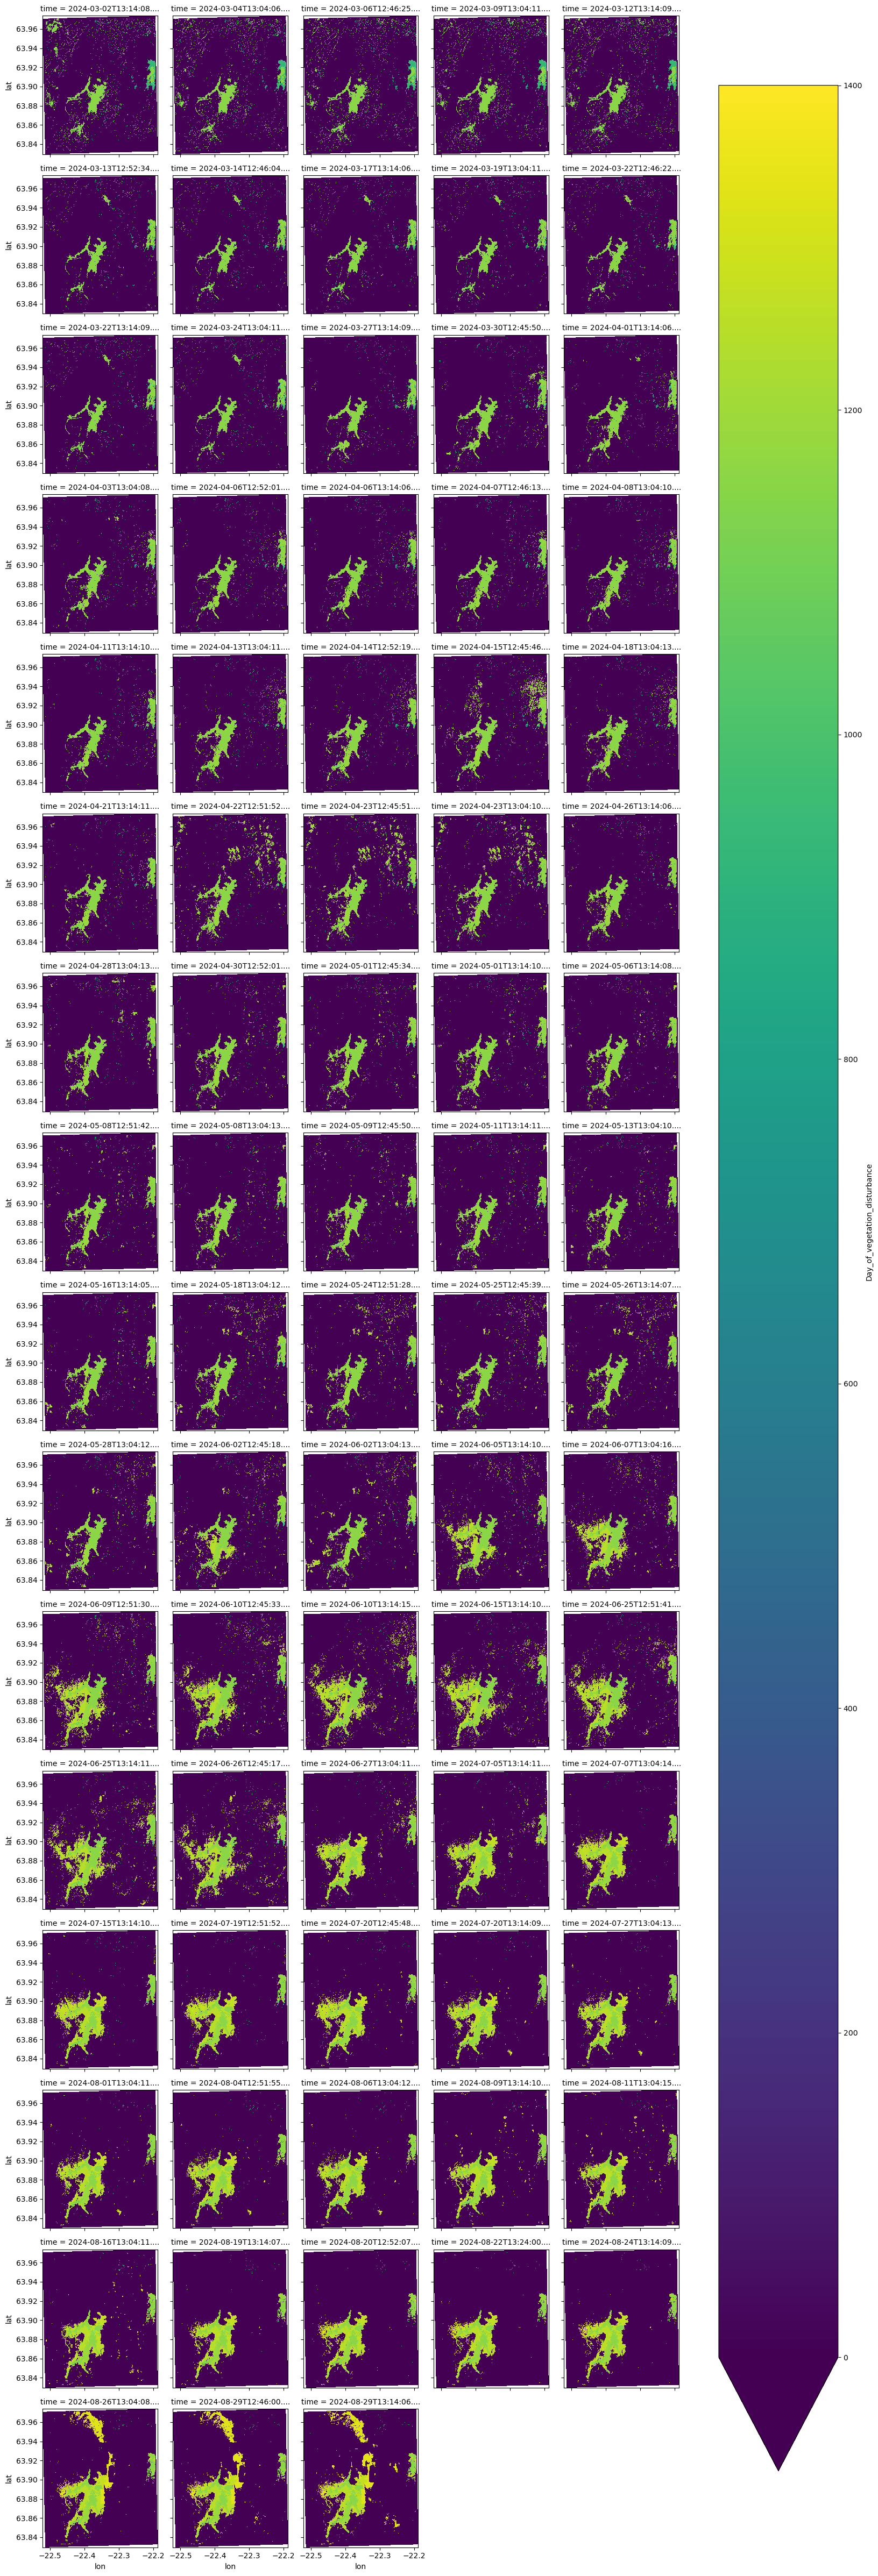

In [42]:
vdt.rio.clip([wkt.loads(aoi)], "epsg:4326").plot(col='time', y='lat', x='lon', col_wrap=5, vmin=0, vmax=1400, cmap='viridis')

In [43]:
vdur_ts, epsg = read_dist_ts(filepaths_dur, time_coords)
vdur_ts = vdur_ts.squeeze("band")

In [44]:
vdur = vdur_ts.copy()
vdur.rio.write_crs(f"epsg:{epsg.split(':')[-1]}", inplace=True)

<xarray.DataArray (time: 78, y: 3660, x: 3660)> Size: 2GB
array([[[-1, -1, -1, ...,  1,  0,  0],
        [-1, -1, -1, ...,  0,  0,  0],
        [-1, -1, -1, ...,  0,  0,  0],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[-1, -1, -1, ...,  1,  0,  0],
        [-1, -1, -1, ...,  0,  0,  0],
        [-1, -1, -1, ...,  0,  0,  0],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[-1, -1, -1, ...,  1,  0,  0],
        [-1, -1, -1, ...,  0,  0,  0],
        [-1, -1, -1, ...,  0,  0,  0],
        ...,
...
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[-1, -1, -1, ...,  0,  0,  0],
        [-1, -1, -1, ...,  0,  0,  0],
        [-1, -1, -1, ...,  0,  0,  0],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[-1, -1, -1, ...,  0,  0,  0],
        [-1, -1, -1, ...,  0,  0,  0],
        [-1, -1, -1, ...,  0,  0,  0],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]]], dtype=int16)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 29kB 7.1e+06 7.1e+06 7.1e+06 ... 6.99e+06 6.99e+06
  * time         (time) object 624B 2024-03-02T13:14:08.525000+00:00 ... 2024...
    spatial_ref  int64 8B 0
Attributes:
    Input_DIST-ALERT_granule:  /OPERA_L3_DIST-ALERT-HLS_T27VVL_20240228T12401...
    Percent_Updated:           98.26
    Units:                     days
    Update_Date:               2024-03-02T13:14:08.525583Z
    Valid_max:                 366
    Valid_min:                 0
    AREA_OR_POINT:             Area
    _FillValue:                -1
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 Number_of_days_of_ongoing_loss_anomalies_since...

In [45]:
xv, yv = np.meshgrid(vdur.x, vdur.y)
transformer = Transformer.from_crs(f"epsg:{epsg.split(':')[-1]}", 
                                   "epsg:4326",
                                   always_xy=True,
                                  ) 

lon, lat = transformer.transform(xv, yv)
vdur.coords['lon'] = (('y', 'x'), lon)
vdur.coords['lat'] = (('y', 'x'), lat)
vdur.attrs['crs']  = '+init=epsg:4326'

In [ ]:
vdur.rio.clip([wkt.loads(aoi)], "epsg:4326").plot(col='time', y='lat', x='lon', col_wrap=5, vmin=0, vmax=200, cmap='viridis')

In [ ]:
# # Assuming `data_array` is your xarray.DataArray with dimensions (t, x, y)
# # Define the threshold range
# lower_bound = 5
# upper_bound = 15

# # Create an empty array to store masked data, with the same shape as data_array
# masked_data_array = xr.full_like(data_array, fill_value=np.nan)

# # Loop over each time step
# for t in range(data_array.sizes['t']):
#     # Extract the data at time t
#     data_slice = data_array.isel(t=t)
    
#     # Calculate the mask for the current time slice
#     mask = (data_slice > lower_bound) & (data_slice < upper_bound)
    
#     # Apply the mask to the current time slice
#     masked_data_array[t] = data_slice.where(mask, other=np.nan)